In [1]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.core.cell_types_cache import ReporterStatus as RS
from allensdk.ephys.feature_extractor import EphysFeatureExtractor
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import pandas as pd
import numpy as np

%matplotlib inline

ctc = CellTypesCache()
cells = ctc.get_cells()
cell_index = {c['id']: c for c in cells}


## Create dataframe to work with. Add cell metadata so we can start filtering 
### new ctc includes all the features in and metadata, so this step is now easier

In [51]:
features_df = pd.DataFrame(data=ctc.get_all_features(require_reconstruction=False))
meta_df = pd.DataFrame(ctc.get_cells(require_reconstruction = False))
df = pd.merge(left = features_df, right = meta_df, how = 'inner', left_on = 'specimen_id', right_on = 'id')                       
df['layer'] = df['structure'].apply(lambda x: x['name'].split(', ')[-1])
df['cell_reporter'] = df['cell_reporter'].apply(lambda x: x['name'])

l5_df = df[(df['layer']=='layer 5') & (df['dendrite_type'] == 'spiny') & (df['cell_reporter'] == 'cre reporter positive')]

#these already exist and we don't need duplicates
l5_df = l5_df.drop('ephys_features', axis = 1)

print len(l5_df)
l5_df.head()

143


,adaptation,average_bifurcation_angle_local,average_bifurcation_angle_remote,average_contraction,average_diameter,average_fragmentation,average_parent_daughter_ratio,avg_isi,electrode_0_pa,f_i_curve_slope,...,specimen_id_path,specimen_tags,sphinx_id,structure,structure_id,tissue_ph,transgenic_line,treatment_id,weight,layer
1,0.064384,NaN,NaN,NaN,NaN,NaN,NaN,76.283333,26.135000,0.195247,...,/567967571/569634384/569642368/569653118/,"[{u'id': 470927414, u'ar_association_key_name'...",290828,"{u'st_level': None, u'graph_id': 1, u'name': u...",613,None,Chrna2-Cre_OE25,598634036,9000,layer 5
15,0.251830,NaN,NaN,NaN,NaN,NaN,NaN,70.105000,42.549998,0.090079,...,/490198918/490503174/490503677/490612844/,"[{u'id': 470927414, u'ar_association_key_name'...",260409,"{u'st_level': None, u'graph_id': 1, u'name': u...",565,None,Rbp4-Cre_KL100,598634036,9000,layer 5
22,0.052803,NaN,NaN,NaN,NaN,NaN,NaN,92.848000,-12.697500,0.184774,...,/567967591/569452872/569453144/569469018/,"[{u'id': 470927414, u'ar_association_key_name'...",290776,"{u'st_level': None, u'graph_id': 1, u'name': u...",778,None,Chrna2-Cre_OE25,598634036,9000,layer 5
24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.145000,11.699376,0.087722,...,/490198922/490696438/490709135/490916919/,"[{u'id': 470927414, u'ar_association_key_name'...",260428,"{u'st_level': None, u'graph_id': 1, u'name': u...",778,None,Rbp4-Cre_KL100,598634036,9000,layer 5
39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,315.800000,-35.611871,0.241894,...,/485955758/486229892/486230127/486235288/,"[{u'id': 470927414, u'ar_association_key_name'...",258348,"{u'st_level': None, u'graph_id': 1, u'name': u...",778,None,Cux2-CreERT2,598634036,9000,layer 5


## Intracortical circuits of pyramidal neurons reflect their long-range axonal targets
### Brown and Hestrin - 2009

In [52]:
l5_df['isi1/isi2'] = None
l5_df['calc_adaptation'] = None
l5_df['spikes'] = None
for i, spec_id in enumerate(l5_df['specimen_id']):
    sweep_number = l5_df['rheobase_sweep_number'].iloc[i]
    data_set = ctc.get_ephys_data(spec_id)
    try:
        spike_times = data_set.get_spike_times(sweep_number)
        if len(spike_times) > 2:
            l5_df['isi1/isi2'].iloc[i] = (spike_times[1]-spike_times[0])/(spike_times[2]-spike_times[1])
            if len(spike_times) > 4:
                spike_times = spike_times[2:]
                l5_df['isi1/isi2'].iloc[i] = (spike_times[1]-spike_times[0])/(spike_times[2]-spike_times[1])
                slope = (spike_times[-1] - spike_times[0])/len(spike_times)
                l5_df['calc_adaptation'].iloc[i] = slope/np.mean(spike_times)
            else:
                l5_df['calc_adaptation'].iloc[i] = 0
        else:
            l5_df['isi1/isi2'].iloc[i] = 0
            l5_df['calc_adaptation'].iloc[i] = 0
    except IOError:
        l5_df['isi1/isi2'].iloc[i] = 0
        l5_df['calc_adaptation'].iloc[i] = 0

### They use 200 ms current pulses that elicit between 6 and 13 spikes. We need to filter our Layer 5 df to just those types of spike to see what we can get

In [54]:
l5_brown = features_df[(features_df['layer']=='layer 5') & (features_df['dendrite'] == 'spiny') & (features_df['cre+'] == 'cre reporter positive')]

l5_brown['paper_sweep'] = None
for i, cell in enumerate(l5_brown['specimen_id']):
    rheo_sweep = l5_brown['rheobase_sweep_number'].iloc[i]
    data_set = ctc.get_ephys_data(cell)
    try:
        sweep_list = data_set.get_sweep_numbers()
        start = sweep_list.index(rheo_sweep)
        for s in range(start,len(sweep_list)):
            sweep_number = sweep_list[s]
            if data_set.get_sweep_metadata(sweep_number)['aibs_stimulus_name'] == 'Long Square':
                spike_train = data_set.get_spike_times(sweep_number)
                if len(spike_train) > 5:
                    if spike_train[5] < 1.22:
                        l5_brown['paper_sweep'].iloc[i] = sweep_number
                        break
    except IOError:
        print cell
        
            
        

### They use the ratio of the first 2 ISIs and then ignore them for the adaptation index, which is the slope of the the remaining ISIs over the mean of the remaining ISIs

In [55]:
l5_brown = l5_brown[l5_brown['paper_sweep'].fillna(0) != 0]
l5_brown['isi1/isi2'] = 0
l5_brown['iratio'] = 0
l5_brown['calc_adapt_index'] = 0
for i, cell in enumerate(l5_brown['specimen_id']):
    sweep = l5_brown['paper_sweep'].iloc[i]
    data_set = ctc.get_ephys_data(cell)

    #reduce ROI window to only include spikes between 1.02 and 1.22 seconds
    spike_times = data_set.get_spike_times(sweep)
    l5_brown['iratio'].iloc[i] = (spike_times[1]-spike_times[0])/(spike_times[2]-spike_times[1])
    for s, spike in enumerate(spike_times):
        if spike > 1.22:
            spike_times = spike_times[2:s]
            break
    isi = []
    for s in range(1,len(spike_times)):
        isi.append(spike_times[s] - spike_times[s-1])
    A = np.vstack([isi, np.ones_like(isi)]).T
    inv_slope,_ = np.linalg.lstsq(A,np.arange(0,len(isi)))[0]
    l5_brown['isi1/isi2'].iloc[i] = (spike_times[1]-spike_times[0])/(spike_times[2]-spike_times[1])
    slope = 1/inv_slope
    l5_brown['calc_adapt_index'].iloc[i] = slope/np.mean(isi)
    

In [56]:
l5_brown.transgenic_line.unique()

array(['Rorb-IRES2-Cre', 'Rbp4-Cre_KL100', 'Scnn1a-Tg2-Cre',
       'Cux2-CreERT2', 'Nr5a1-Cre', 'Scnn1a-Tg3-Cre'], dtype=object)

In [63]:
cell_color_dict = {
    'Cux2-CreERT2':'greenyellow',
     'Nr5a1-Cre':'darkcyan',
     'Scnn1a-Tg2-Cre':'turquoise',
     'Slc17a6-IRES-Cre':'navajowhite',
     'Scnn1a-Tg3-Cre':'aqua',
     'Rorb-IRES2-Cre':'aquamarine',
     'Rbp4-Cre_KL100':'forestgreen',
     'Ctgf-T2A-dgCre':'indigo',              
     'Ctgf-2A-dgCre':'indigo',
     'Ntsr1-Cre_GN220':'cyan',
     'Gad2-IRES-Cre':'darkred',
     'Htr3a-Cre_NO152':'saddlebrown',
     'Pvalb-IRES-Cre':'crimson',
     'Sst-IRES-Cre': 'orange',
     'Vip-IRES-Cre': 'fuchsia'
}


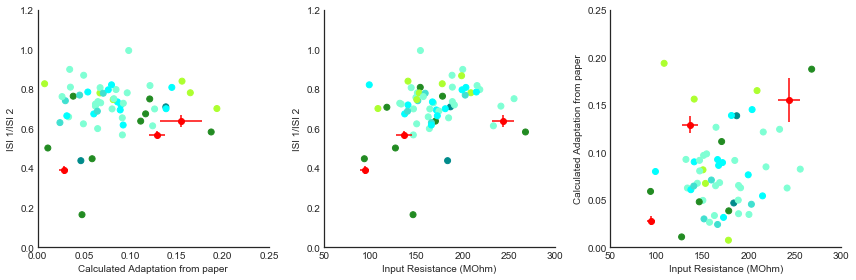

In [61]:
cell_color_listbr = [cell_color_dict[i] for i in l5_brown['transgenic_line']]

fig,axes = plt.subplots(1,3,figsize=(12,4))
axes[0].scatter(l5_brown.calc_adapt_index,l5_brown['iratio'],color = cell_color_listbr)
axes[0].errorbar([0.028,.129,.155],[.39,.57,.64],yerr = [.02,.02,.03], xerr = [.005,.009,.023], color = 'red', fmt = 'o')
axes[0].set_xlabel('Calculated Adaptation from paper')
axes[0].set_ylabel('ISI 1/ISI 2')
axes[0].set_xlim(0,.25)
axes[0].set_ylim(0,1.2)

axes[1].scatter(l5_brown.ri,l5_brown['iratio'],color = cell_color_listbr)
axes[1].errorbar([94.1,136.8,243.7],[.39,.57,.64],yerr = [0.02,0.02,0.03],xerr = [4.6,8.8,11.8],color = 'red',fmt = 'o')
axes[1].set_xlabel('Input Resistance (MOhm)')
axes[1].set_ylabel('ISI 1/ISI 2')
axes[1].set_ylim(0,1.2)
axes[1].set_xlim(50,300)

axes[2].scatter(l5_brown.ri,l5_brown.calc_adapt_index,color = cell_color_listbr)
axes[2].errorbar([94.1,136.8,243.7],[0.028,.129,.155],yerr = [.005,.009,.023], xerr = [4.6,8.8,11.8], color = 'red', fmt = 'o')
axes[2].set_ylabel('Calculated Adaptation from paper')
axes[2].set_xlabel('Input Resistance (MOhm)')
axes[2].set_ylim(0,.25)
axes[2].set_xlim(50,300)
sns.despine()
plt.tight_layout()

# Three Types of Cortical Layer 5 Neurons That Differ in Brain-wide Connectivity and Function
### Kim et al 2015

### Their spike trains come from spiking frequency of 10-20 Hz. They used the slope of the linear regression line fitted to interspike time intervals (ISI), excluding the first four ISIs normalized to the fifth ISIs and plotted as a function of the ISI number (ISI #). In our method, we excluded the first four ISIs as some cells exhibited triplet initial bursts that did not reflect the steady state or "slow" adaptation seen after the fourth ISI. In order to compare our data with Groh et al. one must multiply by 100 as our results are not reported as a percentage. 

In [59]:
l5_kim = l5_df
l5_kim['ISI_initial/ISI_mean'] = None
l5_kim['paper_sweep'] = None
l5_kim['sag_amplitude'] = None
l5_kim['adaptation_index'] = None
for i, cell in enumerate(l5_kim['specimen_id']):
    rheo_sweep = l5_kim['rheobase_sweep_number'].iloc[i]
    data_set = ctc.get_ephys_data(cell)
    try:
        sweep_list = data_set.get_sweep_numbers()
        start = sweep_list.index(rheo_sweep)
        for s in range(start,len(sweep_list)):
            sweep_number = sweep_list[s]
            if data_set.get_sweep_metadata(sweep_number)['aibs_stimulus_name'] == 'Long Square':
                spike_train = data_set.get_spike_times(sweep_number)
                if len(spike_train) >= 10:
                    l5_kim['paper_sweep'].iloc[i] = sweep_number
                    initial_isi = spike_train[1]-spike_train[0]
                    isi = [spike_train[f] - spike_train[f-1] for f in range(1,len(spike_train))]
                    isi_ss = isi[4:]
                    l5_kim['ISI_initial/ISI_mean'].iloc[i] = initial_isi/np.mean(isi_ss)
                    A = np.vstack([isi_ss/isi_ss[0], np.ones_like(isi_ss)]).T
                    inv_slope,_ = np.linalg.lstsq(A,np.arange(0,len(isi_ss)))[0]
                    slope = 1/inv_slope
                    l5_kim['adaptation_index'].iloc[i] = slope/100
                   
                    break
        l5_kim['sag_amplitude'].iloc[i] = (l5_kim['vrest'].iloc[i] - l5_kim['vm_for_sag'].iloc[i])*l5_kim['sag'].iloc[i]
    except IOError:
        print cell

l5_kim = l5_kim[l5_kim['paper_sweep'].fillna('blank') != 'blank']


### Let's look at all the features from their paper

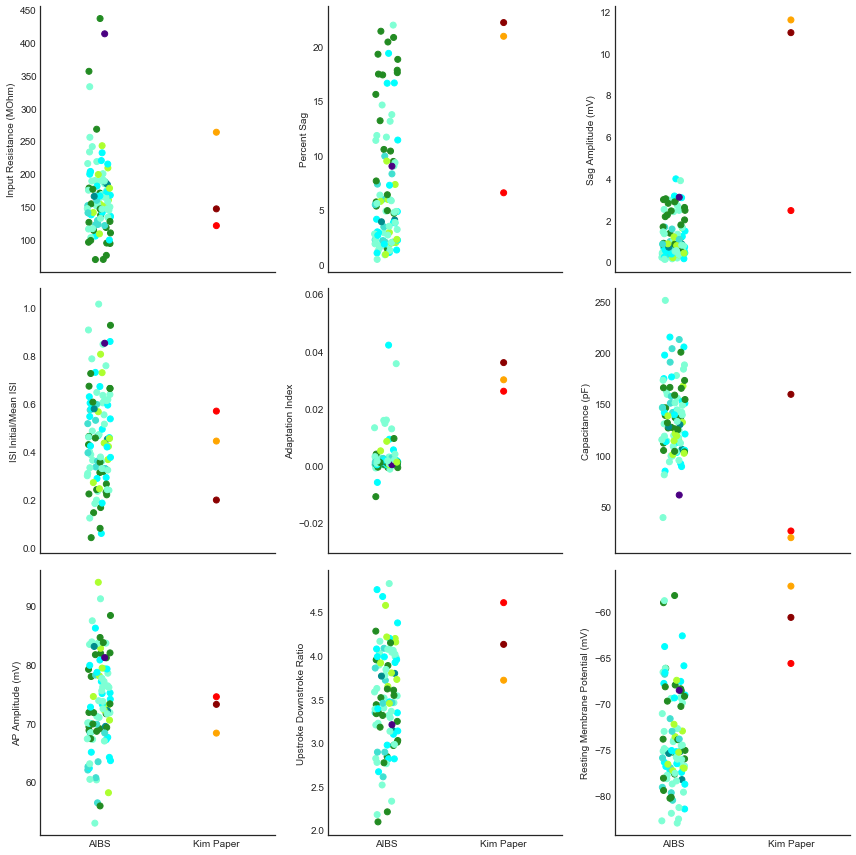

In [65]:
cell_color_listkm = [cell_color_dict[i] for i in l5_kim['transgenic_line']]
kim_color = ['red','darkred','orange']

#set up jitter on the AIBS dataset
x0=np.random.rand(len(l5_kim))*.2-.1

fig,axes = plt.subplots(3,3,figsize=(12,12), sharex=True)
axes[0,0].scatter(x0,l5_kim['ri'],color = cell_color_listkm)
axes[0,0].scatter(np.ones(3),[120.908,146.527,263.372], color = kim_color)
axes[0,0].set_xticks([0,1])
axes[0,0].set_xticklabels(['AIBS','Kim'])
axes[0,0].set_ylabel('Input Resistance (MOhm)')
axes[0,0].set_xlim(-.5,1.5)

axes[0,1].scatter(x0,l5_kim['sag']*100,color = cell_color_listkm)
axes[0,1].scatter(np.ones(3),[6.57,22.19,20.93], color = kim_color)
axes[0,1].set_xticks([0,1])
axes[0,1].set_xticklabels(['AIBS','Kim'])
axes[0,1].set_ylabel('Percent Sag')
axes[0,1].set_xlim(-.5,1.5)

axes[0,2].scatter(x0,l5_kim['sag_amplitude'],color = cell_color_listkm)
axes[0,2].scatter(np.ones(3),[2.46,10.99,11.60], color = kim_color)
axes[0,2].set_xticks([0,1])
axes[0,2].set_xticklabels(['AIBS','Kim'])
axes[0,2].set_ylabel('Sag Amplitude (mV)')
axes[0,2].set_xlim(-.5,1.5)

axes[1,0].scatter(x0,l5_kim['ISI_initial/ISI_mean'],color = cell_color_listkm)
axes[1,0].scatter(np.ones(3),[.568,.197,.443], color = kim_color)
axes[1,0].set_xticks([0,1])
axes[1,0].set_xticklabels(['AIBS','Kim'])
axes[1,0].set_ylabel('ISI Initial/Mean ISI')
axes[1,0].set_xlim(-.5,1.5)

axes[1,1].scatter(x0,l5_kim['adaptation_index'],color = cell_color_listkm)
axes[1,1].scatter(np.ones(3),[.026,.036,.03], color = kim_color)
axes[1,1].set_xticks([0,1])
axes[1,1].set_xticklabels(['AIBS','Kim'])
axes[1,1].set_ylabel('Adaptation Index')
axes[1,1].set_xlim(-.5,1.5)

axes[1,2].scatter(x0,l5_kim['tau']/l5_kim['ri']*1000,color = cell_color_listkm)
axes[1,2].scatter(np.ones(3),[26.30,159.4,19.77], color = kim_color)
axes[1,2].set_xticks([0,1])
axes[1,2].set_xticklabels(['AIBS','Kim'])
axes[1,2].set_ylabel('Capacitance (pF)')
axes[1,2].set_xlim(-.5,1.5)

axes[2,0].scatter(x0,l5_kim['peak_v_long_square']-l5_kim['threshold_v_long_square'],color = cell_color_listkm)
axes[2,0].scatter(np.ones(3),[74.52,73.22,68.32], color = kim_color)
axes[2,0].set_xticks([0,1])
axes[2,0].set_xticklabels(['AIBS','Kim Paper'])
axes[2,0].set_ylabel('AP Amplitude (mV)')
axes[2,0].set_xlim(-.5,1.5)

x_temp=[162.40/35.25,123.54/29.92,119.50/32.14]
axes[2,1].scatter(x0,l5_kim['upstroke_downstroke_ratio_long_square'],color = cell_color_listkm)
axes[2,1].scatter(np.ones(3),x_temp, color = kim_color)
axes[2,1].set_xticks([])
axes[2,1].set_xticklabels(['AIBS','Kim Paper'])
axes[2,1].set_ylabel('Upstroke Downstroke Ratio')
axes[2,1].set_xlim(-.5,1.5)

axes[2,2].scatter(x0,l5_kim['vrest'],color = cell_color_listkm)
axes[2,2].scatter(np.ones(3),[-65.67,-60.68,-57.29], color = kim_color)
axes[2,2].set_xticks([0,1])
axes[2,2].set_xticklabels(['AIBS','Kim Paper'])
axes[2,2].set_ylabel('Resting Membrane Potential (mV)')
axes[2,2].set_xlim(-.5,1.5)

sns.despine()
plt.tight_layout()

### And now let's compare a few features

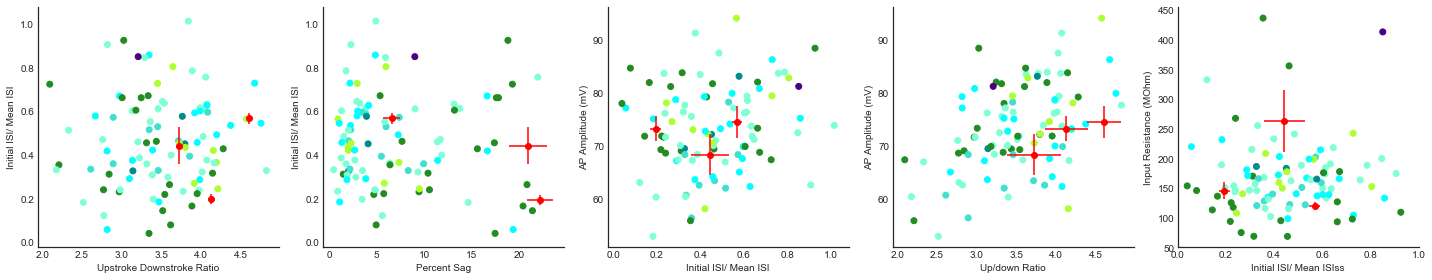

In [66]:
Xfig,axes = plt.subplots(1,5,figsize=(20,4))

axes[0].scatter(l5_kim['upstroke_downstroke_ratio_long_square'],l5_kim['ISI_initial/ISI_mean'], color = cell_color_listkm)
axes[0].errorbar([4.61,4.13,3.72],[.568,.197,.443], yerr = [0.024,0.024,0.086], color = 'red', fmt = 'o')
#plt.annotate('Tlx3',xy=(.568,120.908))
axes[0].set_xlabel('Upstroke Downstroke Ratio')
axes[0].set_ylabel('Initial ISI/ Mean ISI')
#axes[0].set_xlim(0,1)
#axes[0].set_ylim(50,400)

axes[1].scatter(l5_kim['sag']*100,l5_kim['ISI_initial/ISI_mean'], color = cell_color_listkm)
axes[1].errorbar([6.57,22.19,20.93],[.568,.194,.443],xerr = [.88,1.34,2.05], yerr = [0.024,0.024,0.086], color = 'red', fmt = 'o')
axes[1].set_xlabel('Percent Sag')
axes[1].set_ylabel('Initial ISI/ Mean ISI')

axes[2].scatter(l5_kim['ISI_initial/ISI_mean'],l5_kim['peak_v_long_square']-l5_kim['threshold_v_long_square'],color = cell_color_listkm)
axes[2].errorbar([.568,.194,.443],[74.52,73.22,68.32],xerr = [0.024,0.024,0.086], yerr = [2.96,2.32,3.89], color = 'red', fmt = 'o')
axes[2].set_xlabel('Initial ISI/ Mean ISI')
axes[2].set_ylabel('AP Amplitude (mV)')

axes[3].scatter(l5_kim['upstroke_downstroke_ratio_long_square'],l5_kim['peak_v_long_square']-l5_kim['threshold_v_long_square'],color = cell_color_listkm)
x_temp=[162.40/35.25,123.54/29.92,119.50/32.14]
xerr=[3.1/14.35,2.28/8.46,6.57/19.24]
axes[3].errorbar(x_temp,[74.52,73.22,68.32],xerr = xerr, yerr = [2.96,2.32,3.89], color = 'red', fmt = 'o')
axes[3].set_xlabel('Up/down Ratio')
axes[3].set_ylabel('AP Amplitude (mV)')

axes[4].scatter(l5_kim['ISI_initial/ISI_mean'],l5_kim['ri'], color = cell_color_listkm)
axes[4].errorbar([.568,.194,.443],[120.908,146.365,263.372],xerr = [0.024,0.024,0.086], yerr = [6.678,14.527,52.722], color = 'red', fmt = 'o')
axes[4].set_xlabel('Initial ISI/ Mean ISIss')
axes[4].set_ylabel('Input Resistance (MOhm)')
axes[4].set_xlim(0,1)
#axes[4].set_ylim(50,400)

sns.despine()
plt.tight_layout()

### It looks like the Kim et al paper uses a different term for Soma Area. We are using the full surface <br>area of the soma while Kim uses height x width? Taking the 2/3 root of our values gives us sizes<br> on the same order of magnitude

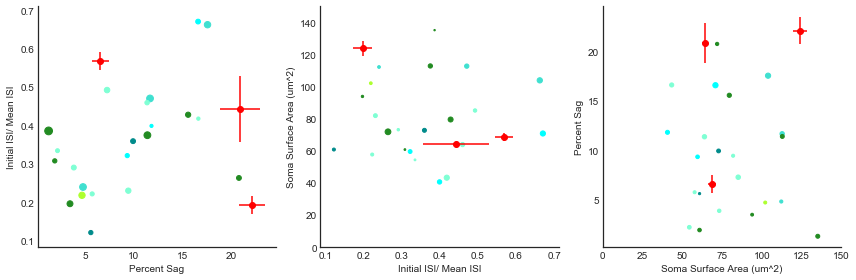

In [76]:
l5_kim_morph = l5_kim[l5_kim['soma_surface'].fillna('no_morpho') != 'no_morpho']

fig,axes = plt.subplots(1,3,figsize=(12,4))
sizes = (l5_kim_morph['soma_surface']/min(l5_kim_morph['soma_surface'])*10)
axes[0].scatter(l5_kim_morph['sag']*100,l5_kim_morph['ISI_initial/ISI_mean'], color = cell_color_listkm, s=sizes)
axes[0].errorbar([6.57,22.19,20.93],[.568,.194,.443],xerr = [.88,1.34,2.05], yerr = [0.024,0.024,0.086], color = 'red', fmt = 'o')
axes[0].set_xlabel('Percent Sag')
axes[0].set_ylabel('Initial ISI/ Mean ISI')

sizes = (l5_kim_morph['sag']/min(l5_kim_morph['sag'])*2)
axes[1].scatter(l5_kim_morph['ISI_initial/ISI_mean'],l5_kim_morph['soma_surface']**(.667), color = cell_color_listkm, s=sizes)
axes[1].errorbar([.568,.197,.443],[68.6,124,64.29],xerr = [.024,.024,.086],yerr = [2.72,4.67,1.58], color = 'red', fmt = 'o')
axes[1].set_xlabel('Initial ISI/ Mean ISI')
axes[1].set_ylabel('Soma Surface Area (um^2)')
axes[1].set_ylim(0,150)

sizes = [float(f/min(l5_kim_morph['ISI_initial/ISI_mean'])*5) for f in l5_kim_morph['ISI_initial/ISI_mean']]
axes[2].scatter(l5_kim_morph['soma_surface']**(.667),l5_kim_morph['sag']*100, color = cell_color_listkm, s=sizes)
axes[2].errorbar([68.6,124,64.29],[6.57,22.19,20.93],xerr = [2.72,4.67,1.58], yerr = [.88,1.34,2.05], color = 'red', fmt = 'o')
axes[2].set_xlabel('Soma Surface Area (um^2)')
axes[2].set_ylabel('Percent Sag')
axes[2].set_xlim(0,150)


sns.despine()
plt.tight_layout()

# Feature Identification

Brown index for 469763389: 0.0342087005412
Kim index for 469763389: 0.0489670979869

Brown index for 490612844: 0.112389424808
Kim index for 490612844: 0.216045473806



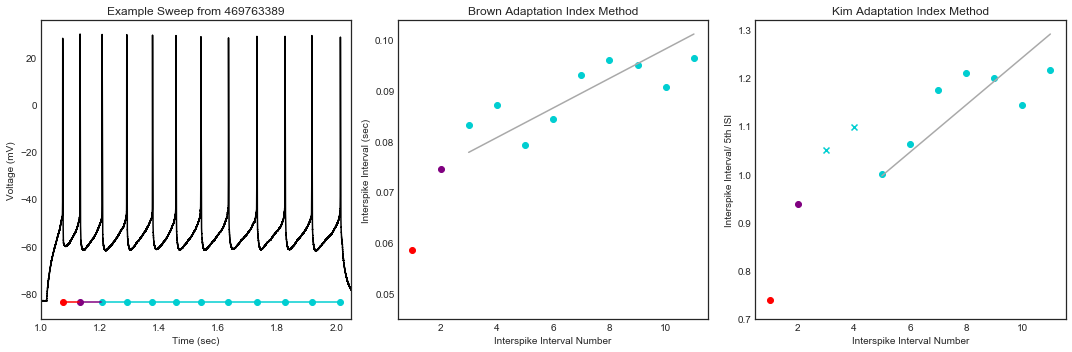

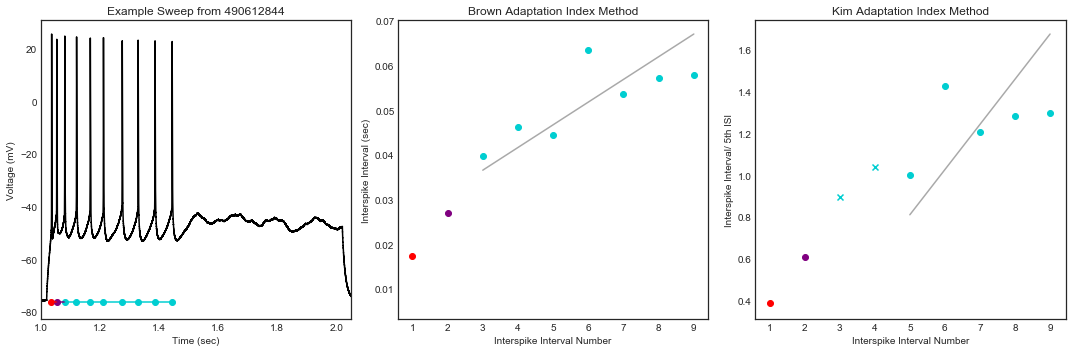

In [69]:
for cell in range(2):
    data_set = ctc.get_ephys_data(l5_kim['specimen_id'].iloc[cell])
    sweep_data = data_set.get_sweep(l5_kim['paper_sweep'].iloc[cell])
    spike_train = data_set.get_spike_times(l5_kim['paper_sweep'].iloc[cell])

    index_range = sweep_data["index_range"]
    i = sweep_data["stimulus"][0:index_range[1]+1] # in A
    v = sweep_data["response"][0:index_range[1]+1] # in V
    i *= 1e12 # to pA
    v *= 1e3 # to mV

    sampling_rate = sweep_data["sampling_rate"] # in Hz
    t = np.arange(0, len(v)) * (1.0 / sampling_rate)

    fig,axes = plt.subplots(1,3,figsize = (15,5))

    axes[0].plot(t,v,color = 'black')
    axes[0].scatter(spike_train[0], v.min(), color = 'red')
    axes[0].plot(spike_train[:2],[v.min(),v.min()],color = 'red')
    axes[0].scatter(spike_train[1], v.min(), color = 'purple')
    axes[0].plot(spike_train[1:3],[v.min(),v.min()],color = 'purple')
    axes[0].scatter(spike_train[2:], np.ones(len(spike_train[2:]))*v.min(), color = 'darkturquoise')
    axes[0].plot(spike_train[2:],np.ones(len(spike_train[2:]))*v.min(),color = 'darkturquoise')
    axes[0].set_xlim(1,2.05)
    axes[0].set_xlabel('Time (sec)')
    axes[0].set_ylabel('Voltage (mV)')
    title = 'Example Sweep from %s' %str(l5_kim['specimen_id'].iloc[cell])
    axes[0].set_title(title)

    isi = [spike_train[f]-spike_train[f-1] for f in range(1,len(spike_train))]
    #find steady state ISIs
    isi_ss = isi[2:]
    #get slope of steady state ISIs
    A = np.vstack([isi_ss, np.ones_like(isi_ss)]).T
    inv_slope,c = np.linalg.lstsq(A,np.arange(0,len(isi_ss)))[0]

    slope = 1/inv_slope
    print 'Brown index for %s: '%str(l5_kim['specimen_id'].iloc[cell]) + str(slope/np.mean(isi))

    axes[1].scatter(1,isi[0], color = 'red')
    axes[1].scatter(2,isi[1], color = 'purple')
    axes[1].scatter(np.arange(len(isi_ss))+3,isi_ss, color = 'darkturquoise')
    axes[1].plot(np.arange(len(isi_ss))+3,np.arange(len(isi_ss))*slope -c*slope, color = 'darkgrey')
    axes[1].set_xlabel('Interspike Interval Number')
    axes[1].set_ylabel('Interspike Interval (sec)')
    axes[1].set_title('Brown Adaptation Index Method')

    isi_ss = isi[4:]
    mean_isi = np.mean(isi_ss)
    A = np.vstack([isi_ss/isi_ss[0], np.ones_like(isi_ss)]).T
    inv_slope,c = np.linalg.lstsq(A,np.arange(0,len(isi_ss)))[0]

    slope = 1/inv_slope
    print 'Kim index for %s: ' %str(l5_kim['specimen_id'].iloc[cell])+ str(slope)
    print ""

    axes[2].scatter(1,isi[0]/isi_ss[0], color = 'red')
    axes[2].scatter(2,isi[1]/isi_ss[0], color = 'purple')
    axes[2].scatter([3,4],isi[2:4]/isi_ss[0], color = 'darkturquoise',marker = 'x')
    axes[2].scatter(np.arange(len(isi_ss))+5,isi_ss/isi_ss[0], color = 'darkturquoise')
    axes[2].plot(np.arange(len(isi_ss))+5,np.arange(len(isi_ss))*slope -c*slope, color = 'darkgrey')
    axes[2].set_xlabel('Interspike Interval Number')
    axes[2].set_ylabel('Interspike Interval/ 5th ISI')
    axes[2].set_title('Kim Adaptation Index Method')


    plt.tight_layout()

# Let's Look at all the Connectivity of V1

In [70]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
all_experiments = mcc.get_experiments(dataframe=True)

### This will give all injections into V1 including secondary injection sites so there will be some error with this

In [71]:
ontology = mcc.get_ontology()

isocortex = ontology['Isocortex']
vis = ontology['VIS']

visl5_cre_experiments = mcc.get_experiments(cre=['Rbp4-Cre_KL100','Scnn1a-Tg3-Cre',
                                                 'Rorb-IRES2-Cre','Tlx3-Cre_PL56',
                                                 'Glt25d2-Cre_NF107','Efr3a-Cre_No108'], 
                                                injection_structure_ids=vis['id'])

print "%d VIS Layer 5, Cre+ experiments" % len(visl5_cre_experiments)

104 VIS Layer 5, Cre+ experiments


In [72]:
visl5_sorted = sorted(visl5_cre_experiments, key=lambda k: k['transgenic-line'])
vis_experiment_ids = [ e['id'] for e in visl5_sorted ]
ctx_children = ontology.get_child_ids([ontology['STR'].id,ontology['SCs'].id,ontology['Isocortex'].id])

pm = mcc.get_projection_matrix(experiment_ids = vis_experiment_ids, 
                               projection_structure_ids = ctx_children,
                               #hemisphere_ids= [], # right hemisphere, ipsilateral
                               parameter = 'projection_density')

row_labels = [f['transgenic-line'] for f in visl5_sorted]
#row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['label'] for c in pm['columns'] ] 
matrix = pm['matrix']

fig, ax = plt.subplots(figsize=(15,15))
heatmap = ax.pcolor(matrix, cmap=plt.cm.afmhot)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(column_labels, minor=False,rotation = 90)
ax.set_yticklabels(row_labels, minor=False)

cbar = plt.colorbar(heatmap)
cbar.set_label('Projection Density', rotation = 270)

plt.show()

TypeError: 'set' object does not support item assignment

In [5]:
matrix

array([[  1.86179000e-03,   2.27817000e-03,   7.21263000e-03, ...,
          6.01182000e-02,   1.51903000e-02,   1.38338000e-01],
       [  9.34443000e-05,   4.43833000e-04,   1.75543000e-01, ...,
          1.23016000e-02,   3.70345000e-02,   8.66645000e-04],
       [  7.64793000e-05,   5.46448000e-06,   2.80856000e-03, ...,
          2.26093000e-03,   3.88504000e-02,   3.82789000e-04],
       ..., 
       [  1.51044000e-09,   5.02576000e-06,   4.60244000e-04, ...,
          8.38051000e-04,   3.17372000e-03,   5.29953000e-05],
       [  1.30136000e-04,   7.21259000e-06,   1.39931000e-05, ...,
          4.28414000e-05,   1.17379000e-03,   6.69569000e-05],
       [  3.01126000e-05,   1.35751000e-07,   3.40457000e-07, ...,
          2.14688000e-05,   4.14145000e-05,   1.50428000e-04]])